In [1]:
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Activation, Input
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Flatten, Reshape, Conv2D, MaxPooling2D, BatchNormalization, Dropout
import numpy as np
import tensorflow as tf
import cv2 as cv
import matplotlib.pyplot as plt
import os
import pickle

In [2]:
def parsing(part):  
    # Путь к папке с изображениями
    dataset_path = 'dataset/data'
    images_path = os.path.join(dataset_path, part, 'images')
    # Путь к папке с метками
    labels_path = os.path.join(dataset_path, part, 'labels')
    images = []
    coords_images = []
    for file_path in sorted(os.listdir(images_path)):
        img_path = images_path + '/' + file_path
        lbl_path = img_path.replace('\images/', '\labels/',).replace('.jpg', '.txt')
        coord = open(lbl_path).read().split('\n')
        high, width = cv.imread(img_path).shape[:2]
        img = cv.imread(img_path)
        for i in range(len(coord)):
            images.append(cv.resize(img, (256,256)))
        for lst in coord:
            lst = lst.split()
            x, y, w, h = int(float(lst[1]) * 256) , int(float(lst[2]) * 256), int(float(lst[3]) * 256) , int(float(lst[4]) * 256)
            coords_images.append([x - w // 2,y - h // 2, x + w // 2, y + h // 2])
    return np.array(images), np.array(coords_images)

In [3]:
def dump_pickle(img,coord,file_name_img, file_name_coord):
    with open(f'files\\{file_name_img}.pickle', 'wb') as file:
        pickle.dump(img, file)
    with open(f'files\\{file_name_coord}.pickle', 'wb') as file:
        pickle.dump(coord, file)

In [3]:
def load_pickle(images, coord):
    with open(f'files\\{images}.pickle', 'rb') as file:
        images = pickle.load(file)
    with open(f'files\\{coord}.pickle', 'rb') as file:
        coord = pickle.load(file)
    return images, coord

In [5]:
# images_train, coord_train = parsing('train')
# images_val, coord_val = parsing('valid')

In [8]:
# dump_pickle(images_train, coord_train,'images_train','coord_train')
# dump_pickle(images_val,coord_val,'images_val','coord_val')

In [4]:
images_train, coord_train = load_pickle('images_train','coord_train')
images_val, coord_val = load_pickle('images_val','coord_val')

In [13]:
for i, image in enumerate(images_train):
    if i % 100 == 0: print(i)
    x, y, w, h = coord_train[i]
    cv.rectangle(
                        image, 
                        (x, y), 
                        (w, h), 
                        (0, 255, 0), 
                        2
                    )
    cv.imshow('Image', image)
    cv.waitKey(0)
    cv.destroyAllWindows()
    

0


KeyboardInterrupt: 

In [9]:
def create_model_loc():
    model = keras.Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),  # свёрточный слой 
    MaxPooling2D((3, 3), strides=3),  # уменьшение карт признаков
    #Dropout(0.2),  # отключение 20 процентов нейронов

    Conv2D(64, (3, 3), activation='relu'),  # свёрточный слой 
    MaxPooling2D((2, 2), strides=2),  # уменьшение карт признаков
    Dropout(0.2),  # отключение 20 процентов нейронов

    Conv2D(128, (3, 3), activation='relu'),  # свёрточный слой
    MaxPooling2D((3, 3), strides=2),  # уменьшение карт признаков
        
    Flatten(),
    Dense(64, activation='relu'),  # обычные нейроны 
    #Dropout(0.2),  # отключение 20 процентов нейронов
    Dense(32, activation='relu'),  # обычные нейроны 
    #Dropout(0.2),  # отключение 20 процентов нейронов
    Dense(16, activation='relu'),  # обычные нейроны 
    Dropout(0.2),  # отключение 20 процентов нейронов
    Dense(4, activation='linear')  # выходной слой 
])
    return model

In [10]:
model = create_model_loc()
model.summary()
model.compile(optimizer='adam',  loss=['mse'], metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 84, 84, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 82, 82, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 41, 41, 64)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 41, 41, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 39, 39, 32)        18464     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 19, 19, 32)       

In [12]:
history = model.fit(images_train, coord_train, epochs = 500, batch_size = 32, validation_data = (images_val, coord_val))

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

In [11]:
model.save('Модели на тест\\third_test.h5')

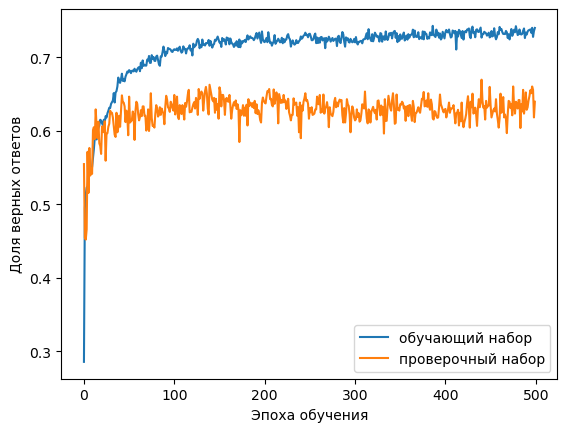

In [11]:
#Вывод графика
plt.plot(history.history['accuracy'],
         label='обучающий набор')
plt.plot(history.history['val_accuracy'],
         label='проверочный набор')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()